# **Klasifikasi 3 Varietas Beras**

# Mengambil *Dataset* dari *Github*


In [ ]:
!apt-get install subversion > /dev/null
!svn export https://github.com/Soedirman-Machine-Learning/rice-varieties-classification/trunk/data > /dev/null

svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'data' already exists


# Persiapan 
Program ini dibuat untuk membedakan 3 varietas beras yaitu :

1.   Varietas Beras Basmathi
2.   Varietas Beras IR 64
3.   Varietas Beras Ketan

Pada program ini menggunakan metode *Convolutional Neural Network* (CNN) untuk melakukan klasifikasinya.

# Memasukan Fungsi *Library*

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

# Mengimpor *Dataset*

In [5]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls data/image
!ls data/image/train
!ls data/image/train/Basmathi
!ls data/image/train/IR64
!ls data/image/train/Ketan

NameError: name 'sudah_perkelas' is not defined

In [11]:
import bb_utils
mypath = input()

https://drive.google.com/drive/folders/1aIN-PkHG7nDlLsv4ghHbjPgtj2ToE3X2?usp=sharing


In [12]:
#Perintah untuk memvisualisasikan salah satu gambar dari data train
image = imread("data_train/bangunan/1.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

FileNotFoundError: No such file: 'D:\Data Dipta\univ\sem 6\DL\tubes\data_train\bangunan\1.jpg'

In [ ]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('data/image/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Basmathi', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 180 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset validation (validasi) adalah: (45, 224, 224, 3) (45, 3)
Bentuk array dari dataset test (pengujian) adalah: (45, 224, 224, 3) (45,)


# Menyimpan Label

In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Basmathi': 0, 'IR64': 1, 'Ketan': 2}


In [ ]:
!cat labels.txt

Basmathi
IR64
Ketan

# Membuat Model dari Jaringan CNN yang Sudah Dipelajari Sebelumnya (*pre-trained convnets*)

In [ ]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

# *Feature Extraction* 
Menggunakan model pre-trained untuk ekstraksi fitur (feature extraction) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama. Ini dilakukan dengan membuat contoh model pre-trained dan menambahkan classifier yang sepenuhnya terhubung di atas. Model pre-trained adalah "beku" dan hanya bobot pengklasifikasi yang diperbarui selama pelatihan. Dalam hal ini, basis konvolusional mengekstraksi semua fitur yang terkait dengan setiap gambar dan Anda baru saja melatih classifier yang menentukan kelas gambar mengingat set fitur yang diekstraksi.

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

# Mengelompokkan Klasifikasi Tiga Jenis Beras dengan *Deep Learning* (*Convolutional Neural Network*) 
Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

# Mempersiapkan Data Masukkan Pengujian

In [ ]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

# Pembuatan Model (Menambah Model)

In [ ]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          294944    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 3,523,907
Trainable params: 295,043
Non-trainable params: 3,228,864
_________________________________________________________________


# Pelatihan

In [ ]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
#ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit_generator(train_generator, 
                    epochs=40, 
                    validation_data=val_generator)
#history = model.fit(x = X_train3, y = y_train3, batch_size=120, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
2/2 [==============================] - 6s 3s/step - loss: 4.2025 - acc: 0.3611 - val_loss: 0.4500 - val_acc: 0.8000
Epoch 2/40
2/2 [==============================] - 3s 2s/step - loss: 0.8028 - acc: 0.6556 - val_loss: 0.7944 - val_acc: 0.6222
Epoch 3/40
2/2 [==============================] - 3s 1s/step - loss: 0.6898 - acc: 0.6389 - val_loss: 0.4806 - val_acc: 0.7111
Epoch 4/40
2/2 [==============================] - 3s 2s/step - loss: 0.2792 - acc: 0.8889 - val_loss: 0.1858 - val_acc: 0.9556
Epoch 5/40
2/2 [==============================] - 3s 1s/step - loss: 0.1323 - acc: 0.9833 - val_loss: 0.0783 - val_acc: 0.9778
Epoch 6/40
2/2 [==============================] - 3s 1s/step - loss: 0.1008 - acc: 0.9667 - val_loss: 0.0577 - val_acc: 1.0000
Epoch 7/40
2/2 [==============================] - 3s 2s/step - loss: 0.0458 - acc: 0.9944 - val_loss: 0.1189 - val_acc: 0.9333
Epoch 8/40
2/2 [==============================] - 3s 2s/step - loss: 0.0449 - acc: 1.0000 - val_loss: 0.0635 - 

# Menggambarkan Hasil Pelatihan

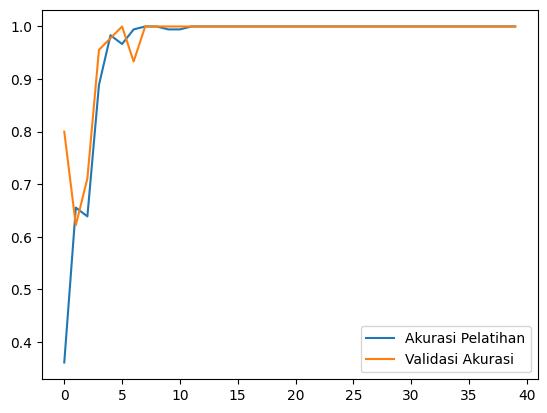

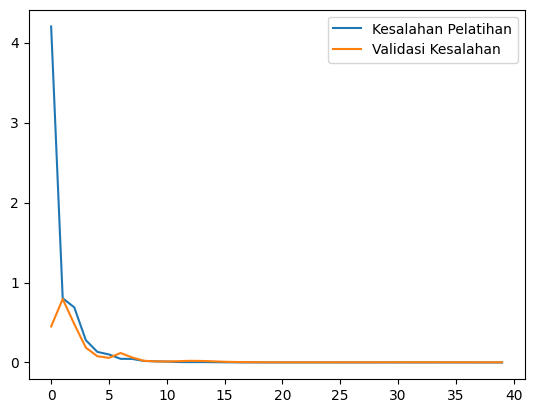

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

# Menggunakan Model

In [ ]:
#Prediksi Label Validasi dengan Pelatihan
n = 44
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [1. 0. 0.]
Prediksinya adalah [1.00e+00 2.46e-12 3.13e-12]


Hasil tersebut merupakan hasil prediksi dari training dari 3 jenis data pelatihan yaitu jenis beras Basmathi, IR 64, dan Ketan. Menggunakan inputan gambar dengan piksel 224 x 224, 1 filter dengan fungsi aktivasi relu, dan 1 layer output dengan fungsi aktivasi softmax

# Evaluasi

In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3))

['loss', 'acc']
2/2 [==============================] - 1s 55ms/step - loss: 0.0012 - acc: 1.0000
[0.0011561018181964755, 1.0]


In [ ]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]


# Prediksi Gambar Individual

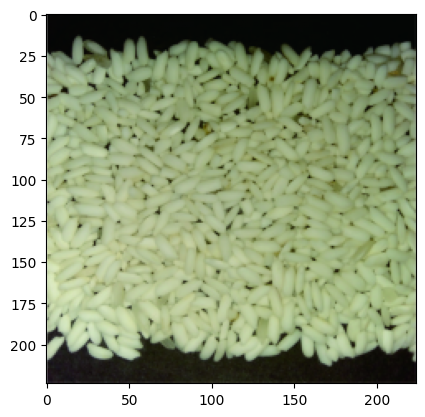

Label yang benar adalah: 2 : Ketan
Nilai yang diprediksi adalah: [7.49e-06 1.07e-04 1.00e+00]
Label yang diprediksi adalah: 2 : Ketan
Prediksi benar


In [ ]:
n = 44 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

# *Confusion Matrix*

Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


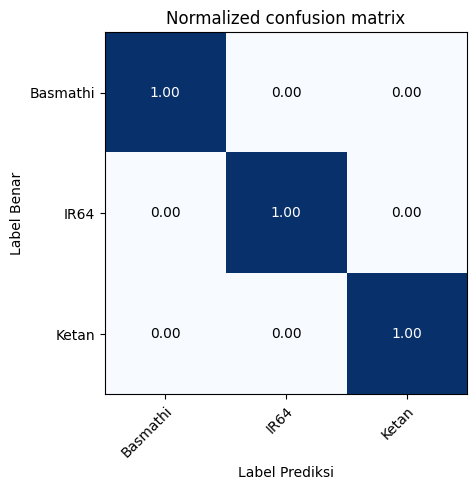

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

# Menyimpan dan Konversi ke ".tflite" 
Menyimpan model menggunakan tf.saved_model.save dan kemudian mengonversi model tersimpan ke format yang kompatibel tf lite.

In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_3_Varietas_Beras_MobileNet.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets
